#  Lab Assignment Seven: Sequential Network Architectures

Name 1: Jadon Swearingen (5000)
Name 2: Ephraim Sun (7000)
Name 3: Adeeb Abdul Taher (7000)


In this lab, you will select a prediction task to perform on your dataset, evaluate a sequential architecture and tune hyper-parameters. If any part of the assignment is not clear, ask the instructor to clarify. 

### Dataset Selection

Dataset: https://www.kaggle.com/datasets/rajatkumar30/fake-news

We have chosen a fake news dataset where given the title and text of the article, we should predict if the news is fake or real. 

### Preparation

[1 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed). Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). Discuss methods of tokenization in your dataset as well as any decisions to force a specific length of sequence.  


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import nltk, re, string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model # type: ignore
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Flatten, Dropout, Layer
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras import Sequential
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

import itertools

mpl.style.use("seaborn-v0_8-deep")
mpl.rcParams["figure.figsize"] = (20, 5)
mpl.rcParams["figure.dpi"] = 100
plt.rcParams["figure.dpi"] = 100
plt.rcParams["lines.linewidth"] = 2

In [43]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer

In [44]:
nltk.download("vader_lexicon")
nltk.download("punkt")
nltk.download("stopwords")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ephraim888sun/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ephraim888sun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ephraim888sun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [45]:
# Load dataset

df = pd.read_csv("./dataset/news.csv")

# Load less data
df =df.head(1000)


df

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...,...
995,8473,Clintons Are Under Multiple FBI Investigations...,Clintons Are Under Multiple FBI Investigations...,FAKE
996,5606,"First Iraqi Troops Enter Mosul, But Fighting R...",Military: Goal Is to 'Liberate' Eastern Bank o...,FAKE
997,5753,SHOCK VIDEO : Hillary Needs Help Climbing ONE ...,SHOCK VIDEO : Hillary Needs Help Climbing ONE ...,FAKE
998,2775,"After vowing to end two wars, Obama may leave ...",President Obama’s decision to expand the U.S. ...,REAL


#### Preprocess Data

This function performs several preprocessing steps on the input DataFrame:
1. Converts the 'title' and 'text' columns to string type to ensure consistency.
2. Encodes the 'label' column, mapping 'FAKE' to 1 and 'REAL' to 0, to prepare for machine learning algorithms.
3. Drops the 'Unnamed: 0' column which is often an artifact from reading files with an index.
4. Combine the article text + article together
5. Clean the text by lowercasing everything, removing stopwords, and removing non-alphabetic characters.

In [46]:
def cleanText(txt):
      
    #Creates list of possible stopwords from nltk library
    stop = stopwords.words('english')
    
    # Lowercase
    txt = txt.lower()
    
    # Remove stopwords
    txt = ' '.join([word for word in txt.split() if word not in (stop)])
    
    # Remove non-alphabetic characters
    txt = re.sub('[^a-z]',' ',txt)
    return txt  


def pre_process(df):
    """
    Parameters:
    - df (pd.Dataframe): The DataFrame to be preprocessed

    Returns: 
    - df (pd.DataFrame): The DataFrame after preprocessed

    """

    columns = ["title", "text"]
    for col in columns:
        df[col] = df[col].astype(str)  # Convert each column to string

    # Map 'label' values from 'FAKE'/'REAL' to 1/0
    df["label"] = df["label"].map({"FAKE": 1, "REAL": 0})

    # Remove the 'Unnamed: 0' column, if it exists, as it's usually an artifact
    df = df.drop(["Unnamed: 0"], axis=1)


    # Combining text and title for creating full news article with headline
    df['final_news'] = df['title'] + " " + df['text']

    # Cleaning the text
    df['final_news'] = df['final_news'].apply(cleanText)

    return df

In [47]:
def num_characters(df, col_name):
    """
    Adds a new column to the DataFrame containing the number of characters in each message.

    Parameters:
    - df: DataFrame. The DataFrame to which the new column will be added.
    - col_name: str. The name of the column containing the messages.

    Returns:
    - DataFrame. The original DataFrame with a new column added.
    """

    df["Characters"] = df[col_name].apply(len)
    return df


def num_sentences(df, col_name):
    """
    Adds a new column to the DataFrame containing the number of sentences in each message.

    Parameters:
    - df: DataFrame. The DataFrame to which the new column will be added.
    - col_name: str. The name of the column containing the messages.

    Returns:
    - DataFrame. The original DataFrame with a new column added.
    """
    df["Sentences"] = df[col_name].apply(lambda x: len(nltk.sent_tokenize(x)))
    return df


def num_words(df, col_name):
    """
    Adds a new column to the DataFrame containing the number of words in each message.

    Parameters:
    - df: DataFrame. The DataFrame to which the new column will be added.
    - col_name: str. The name of the column containing the messages.

    Returns:
    - DataFrame. The original DataFrame with a new column added.
    """
    df["Words"] = df[col_name].apply(lambda x: len(nltk.word_tokenize(x)))
    return df


In [48]:
def pie_plot(df, col_name):
    """
    Creates a pie plot to show the distribution of real and fake news in the DataFrame.

    Parameters:
    - df: DataFrame. The DataFrame containing the data.
    - col_name: str. The name of the column containing the labels.

    Returns:
    - None. Displays a pie plot.
    """
    sizes = df["label"].value_counts()
    labels = ["Real", "Fake"]
    colors = ["#ff9999", "#66b3ff"]

    plt.pie(
        sizes,
        autopct="%1.1f%%",
        colors=colors,
        startangle=90,
        explode=(0.1, 0),
        shadow=True,
    )

    plt.title("Distribution of Real and Fake News in " + col_name)
    plt.legend(labels, title="News Type", loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()

In [49]:
def plot_distribution_features(df, features, col_name):
    """
    Plot distributions of specified features in a DataFrame, comparing 'Real' and 'Fake' news.

    Parameters:
    - df: DataFrame containing the data.
    - features: List of strings, names of the columns for which to plot the distributions.

    Each feature's distribution is plotted in a separate row, with 'Real' news in blue and 'Fake' news in pink.
    """
    # Create a figure with subplots arranged in 3 rows and 1 column
    fig, axes = plt.subplots(
        nrows=len(features), ncols=1, figsize=(15, 6 * len(features))
    )

    for i, feature in enumerate(features):
        # Plot distribution for 'Real' news
        sns.histplot(
            df[df["label"] == 0][feature],
            kde=True,
            color="#66b3ff",
            label="Real",
            ax=axes[i],
        )
        # Plot distribution for 'Fake' news
        sns.histplot(
            df[df["label"] == 1][feature],
            kde=True,
            color="#ff9999",
            label="Fake",
            ax=axes[i],
        )
        # Setting the title for each subplot
        axes[i].set_title(f"{feature} Distribution for {col_name} dataset")
        # Setting the labels for each subplot
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel("Count")
        # Adding legend to each subplot
        axes[i].legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [50]:
df = pre_process(df)

In [51]:
df

,title,text,label,final_news
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",1,smell hillary s fear daniel greenfield shillm...
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,1,watch exact moment paul ryan committed politic...
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,0,kerry go paris gesture sympathy u s secretary...
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",1,bernie supporters twitter erupt anger dnc we...
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,0,battle new york primary matters primary day n...
...,...,...,...,...
995,Clintons Are Under Multiple FBI Investigations...,Clintons Are Under Multiple FBI Investigations...,1,clintons multiple fbi investigations agents st...
996,"First Iraqi Troops Enter Mosul, But Fighting R...",Military: Goal Is to 'Liberate' Eastern Bank o...,1,first iraqi troops enter mosul fighting remai...
997,SHOCK VIDEO : Hillary Needs Help Climbing ONE ...,SHOCK VIDEO : Hillary Needs Help Climbing ONE ...,1,shock video hillary needs help climbing one ...
998,"After vowing to end two wars, Obama may leave ...",President Obama’s decision to expand the U.S. ...,0,vowing end two wars obama may leave three beh...


In [52]:
df = num_characters(df, "final_news")
df = num_sentences(df, "final_news")
df = num_words(df, "final_news")

In [53]:
df

,title,text,label,final_news,Characters,Sentences,Words
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",1,smell hillary s fear daniel greenfield shillm...,5218,1,740
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,1,watch exact moment paul ryan committed politic...,1987,1,277
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,0,kerry go paris gesture sympathy u s secretary...,1865,1,259
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",1,bernie supporters twitter erupt anger dnc we...,2154,1,265
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,0,battle new york primary matters primary day n...,1372,1,206
...,...,...,...,...,...,...,...
995,Clintons Are Under Multiple FBI Investigations...,Clintons Are Under Multiple FBI Investigations...,1,clintons multiple fbi investigations agents st...,306,1,36
996,"First Iraqi Troops Enter Mosul, But Fighting R...",Military: Goal Is to 'Liberate' Eastern Bank o...,1,first iraqi troops enter mosul fighting remai...,921,1,129
997,SHOCK VIDEO : Hillary Needs Help Climbing ONE ...,SHOCK VIDEO : Hillary Needs Help Climbing ONE ...,1,shock video hillary needs help climbing one ...,565,1,80
998,"After vowing to end two wars, Obama may leave ...",President Obama’s decision to expand the U.S. ...,0,vowing end two wars obama may leave three beh...,5699,1,796


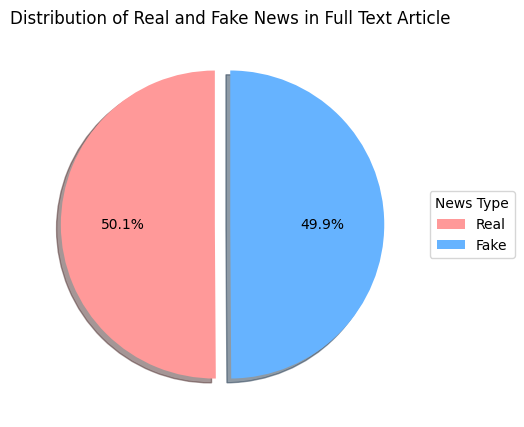

In [54]:
pie_plot(df, "Full Text Article")

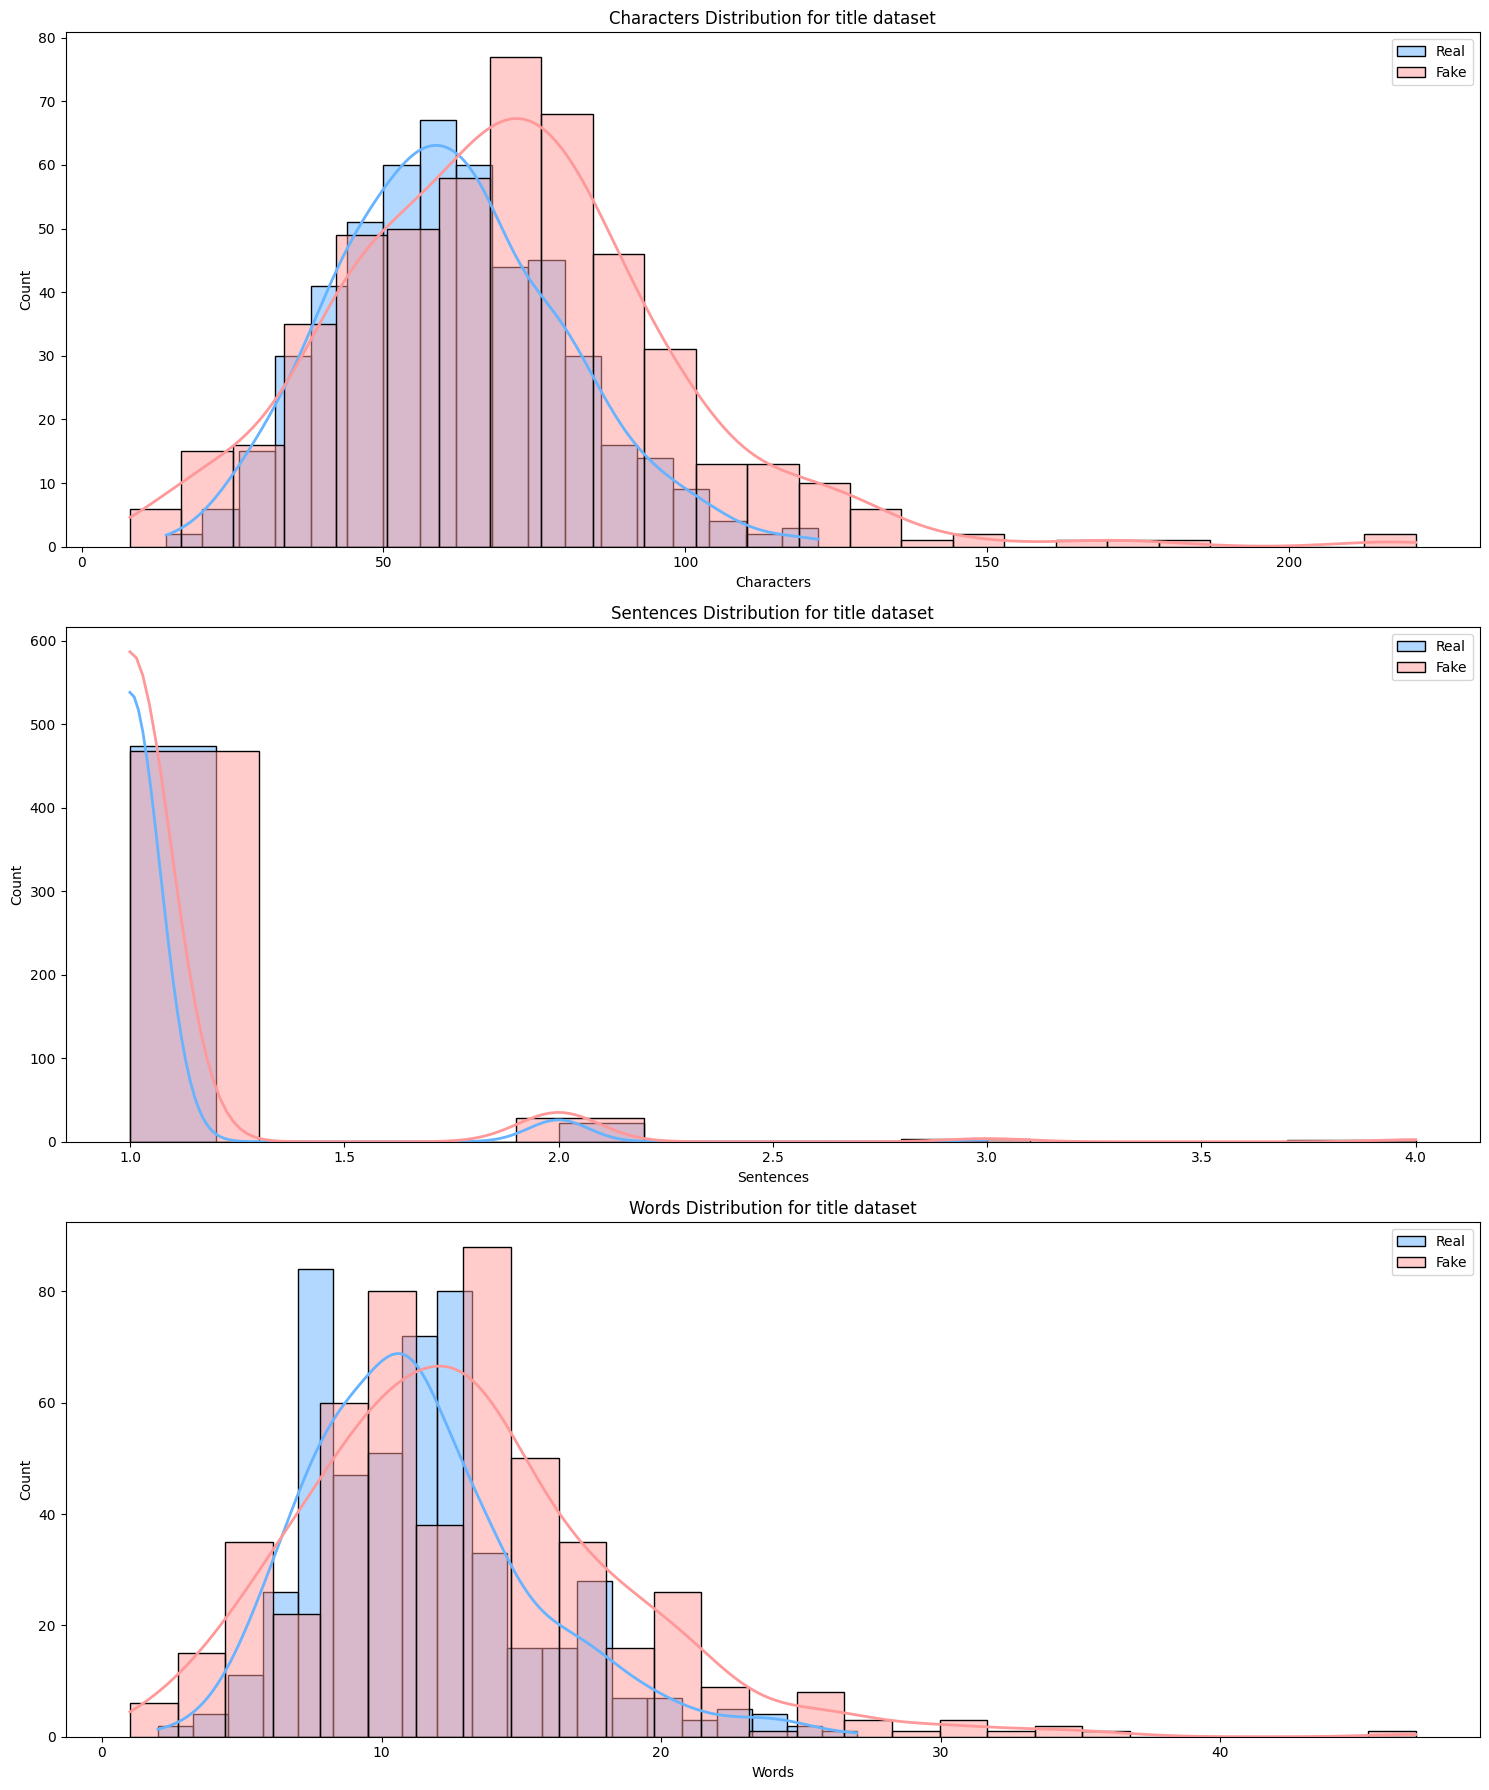

In [55]:
# Plot distribution of the title column
df_title = df

df_title = num_characters(df_title, "title")
df_title = num_sentences(df_title, "title")
df_title = num_words(df_title, "title")

plot_distribution_features(df_title, ["Characters", "Sentences", "Words"], "title")

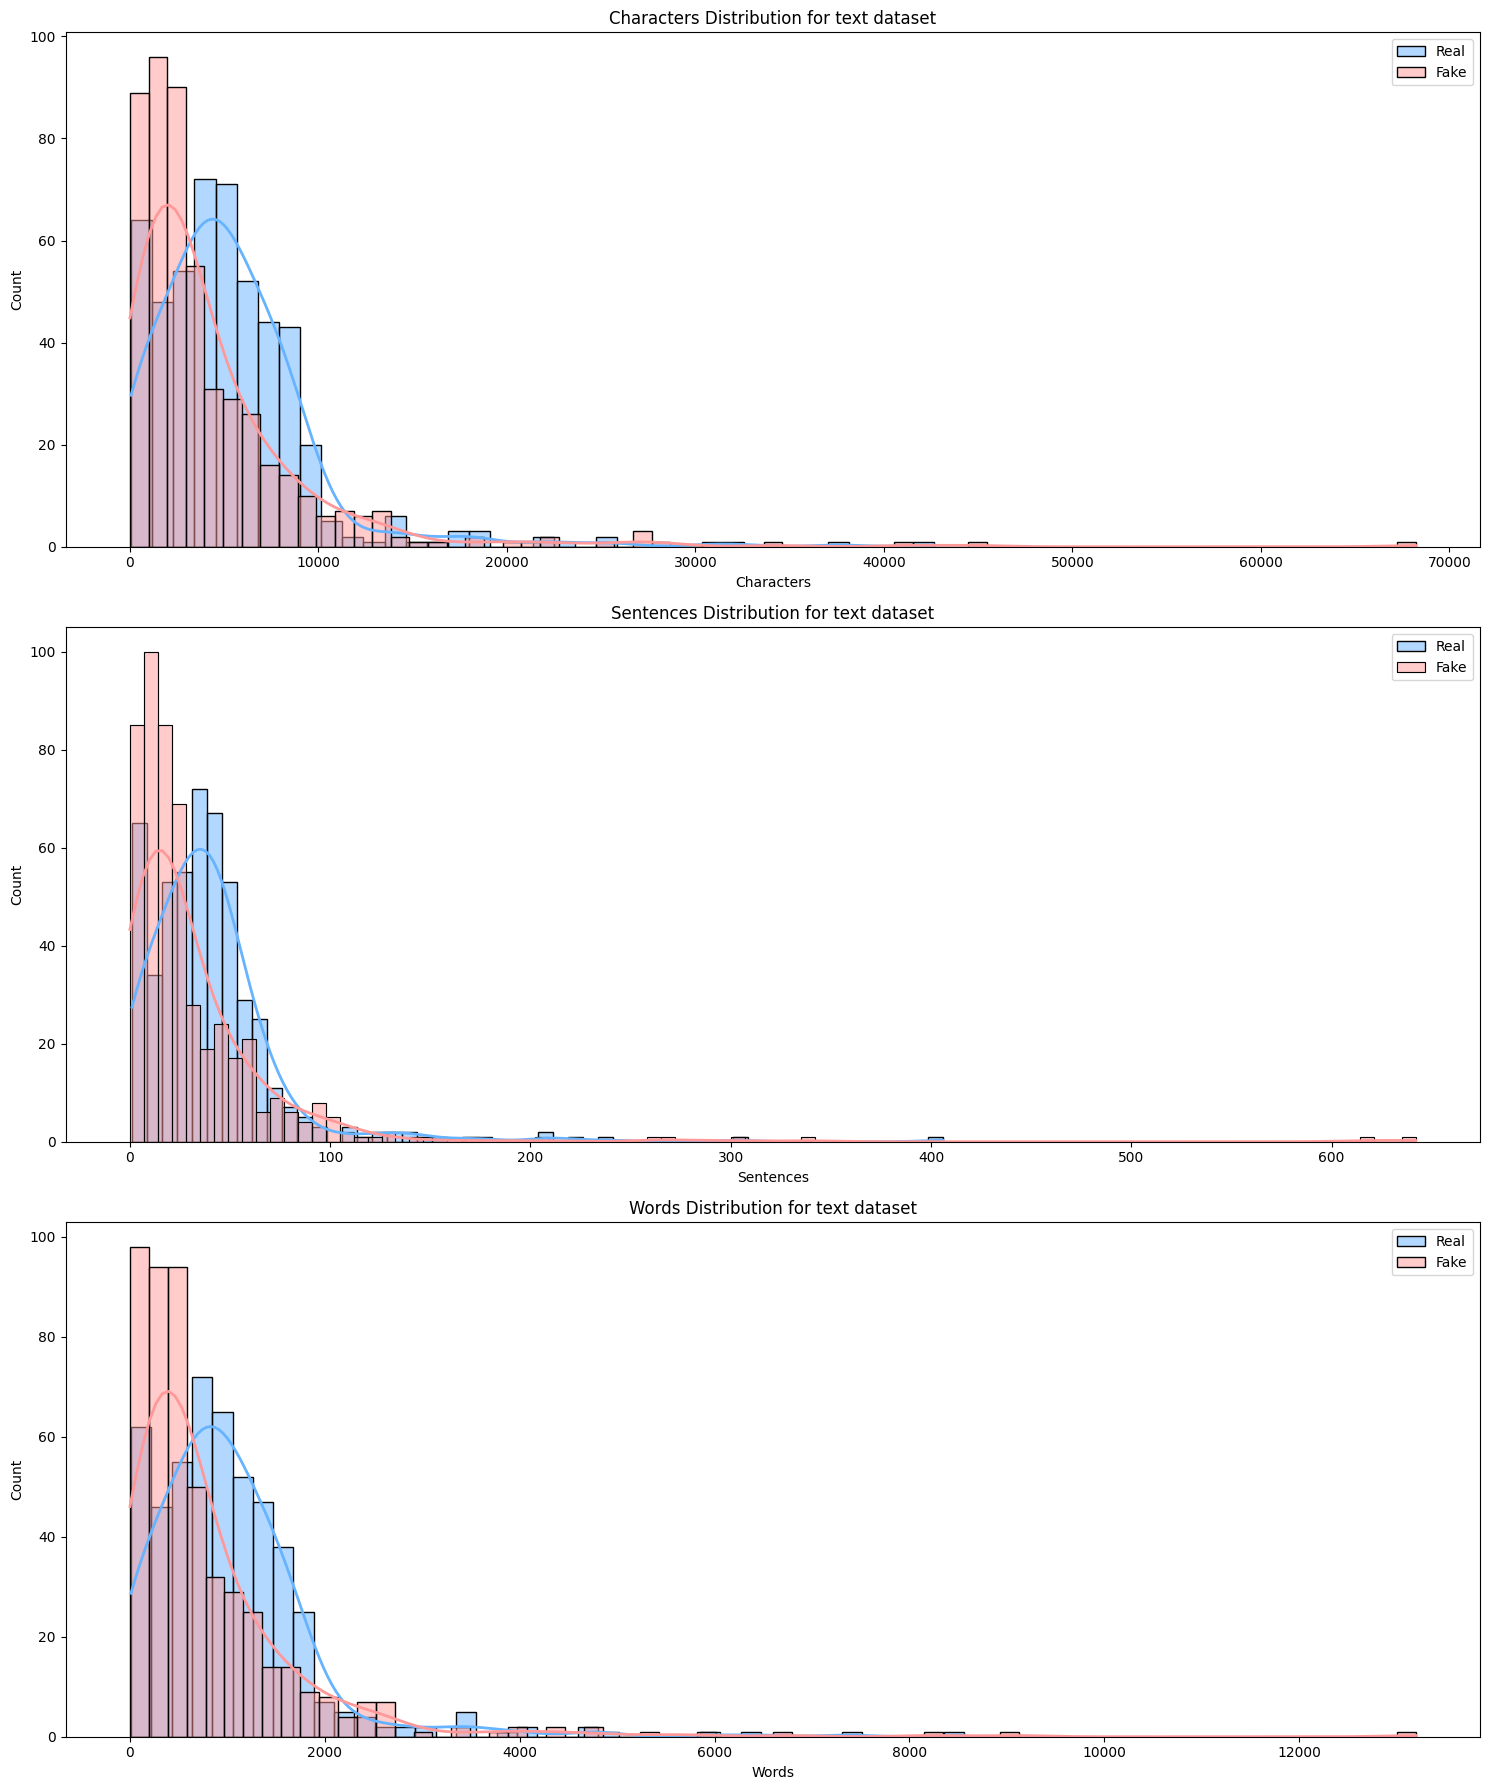

In [56]:
# Plot distribution of the text column
df_text = df

df_text = num_characters(df_text, "text")
df_text = num_sentences(df_text, "text")
df_text = num_words(df_text, "text")

plot_distribution_features(df_text, ["Characters", "Sentences", "Words"], "text")

In [57]:
# Variable Representation for Model
X = df['final_news'].values
y = df['label'].values

# Tokenize the text data
vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

# Determine input length
text_lengths = [len(seq) for seq in X]
avg_length = np.mean(text_lengths)
std_length = np.std(text_lengths)
input_length = int(avg_length + std_length)


# Pad sequences
# input_length = max(len(seq) for seq in X)
max_sequence_length = 100
X = pad_sequences(X, maxlen=max_sequence_length, padding='post', truncating='post')

# Determine vocabulary size
input_dim = len(tokenizer.word_index) + 1

# Define variables
output_dim = 100  # Modify this as per your requirements
params = (input_dim, output_dim, input_length)


[1 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.


We have decided on the following metrics

Precision: Precision is the ratio of true positive predictions (correctly identifying fake news) to the total number of positive predictions (both true positives and false positives). Precision indicates the algorithm's ability to correctly identify fake news without mistakenly classifying real news as fake. In the context of fake news detection, precision is crucial because incorrectly labeling legitimate news as fake can have serious consequences, including reputational damage to news sources and misinformation propagation.

Recall (Sensitivity): Recall is the ratio of true positive predictions to the total number of actual positive instances (both true positives and false negatives). Recall measures the algorithm's ability to correctly identify all instances of fake news in the dataset. A high recall indicates that the algorithm can effectively detect most of the fake news samples, minimizing the risk of allowing misinformation to spread.

F1 Score: The F1 score is the harmonic mean of precision and recall. It provides a balanced assessment of the algorithm's performance by taking both precision and recall into account. The F1 score is particularly useful when there is an uneven distribution of classes in the dataset, as it considers false positives and false negatives.

Specificity: Specificity is the ratio of true negative predictions (correctly identifying real news) to the total number of actual negative instances (both true negatives and false positives). Specificity measures the algorithm's ability to correctly identify real news without mistakenly classifying it as fake. While precision focuses on the positive class (fake news), specificity provides insights into the algorithm's performance in accurately identifying the negative class (real news).

Area Under the Receiver Operating Characteristic Curve (AUC-ROC): The AUC-ROC is a widely used metric that evaluates the algorithm's overall performance across different threshold settings. It measures the trade-off between the true positive rate (sensitivity) and the false positive rate (1 - specificity) at various classification thresholds. A higher AUC-ROC score indicates better overall performance, considering both true positives and true negatives.

[1 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your train/test splitting method is a realistic mirroring of how an algorithm would be used in practice. 


We have decided to utilize Stratified 10-fold Cross-Validation:


Handling Class Imbalance: Since your dataset contains an equal distribution of fake news and real news samples, using stratified sampling ensures that each fold of the cross-validation maintains the same proportion of both classes. This is particularly important when dealing with imbalanced datasets, where one class is significantly more prevalent than the other. By maintaining class balance in each fold, the evaluation becomes more representative of the model's performance on unseen data.

Robust Performance Evaluation: Cross-validation provides a more robust estimate of your model's performance by iteratively training and testing the model on different subsets of the data. In Stratified 10-fold Cross-Validation, the dataset is divided into ten equal parts (folds), with each fold serving as the testing set once while the remaining nine folds are used for training. By averaging the performance metrics across all folds, you obtain a more reliable assessment of the model's generalization ability.

Mitigating Overfitting: Cross-validation helps in detecting and mitigating overfitting issues. Overfitting occurs when a model performs well on the training data but fails to generalize to unseen data. With Stratified 10-fold Cross-Validation, the model is exposed to multiple training and testing subsets. If the model consistently performs well across all folds, it indicates that it has learned patterns that are generalizable and not specific to a particular subset.

Optimal Hyperparameter Tuning: Cross-validation is commonly used for hyperparameter tuning. It allows you to evaluate different sets of hyperparameters on the training folds and select the best combination based on the average performance across the testing folds. This helps in finding the optimal hyperparameters that yield the best performance on unseen data.

Realistic Mirroring of Model Usage: Stratified 10-fold Cross-Validation provides a realistic reflection of how the model would be used in practice. It simulates the scenario where the model is trained on a large dataset and tested on unseen data. This approach is especially useful when you don't have a separate validation or holdout dataset for model evaluation.

In [58]:
kf = KFold(n_splits=2, shuffle=True, random_state=42)

### Modeling

[3 points] Investigate at least two different sequential network architectures (e.g., a CNN and a Transformer). Alternatively, you may also choose a recurrent network and Transformer network. Be sure to use an embedding layer (try to use a pre-trained embedding, if possible). Adjust one hyper-parameter of each network to potentially improve generalization performance (train a total of at least four models). Visualize the performance of training and validation sets versus the training iterations, showing that the models converged.

In [59]:
# Simple RNN Model
def rnn_model(input_dim, output_dim, input_length):

    # Define the model architecture
    model = Sequential([
        # Embedding layer
        Embedding(input_dim, output_dim, input_length=input_length),
        
        # LSTM layers
        SimpleRNN(128, return_sequences=True),
        SimpleRNN(64),
        
        # Dense output layer
        Dense(1, activation='sigmoid')  # Dense layer with 1 unit and sigmoid activation for binary classification
    ])

    return model

In [60]:
# LSTM Model
def lstm_model(input_dim, output_dim, input_length):

    # Define the model architecture
    model = Sequential([
        # Embedding layer
        Embedding(input_dim, output_dim, input_length=input_length),
        
        # LSTM layers
        LSTM(64, return_sequences=True),  # LSTM layer with 64 units and returns sequences
        LSTM(32),  # LSTM layer with 32 units
        
        # Dense output layer
        Dense(1, activation='sigmoid')  # Dense layer with 1 unit and sigmoid activation for binary classification
    ])

    return model

In [61]:
# GRU Model
def gru_model(input_dim, output_dim, input_length):

    # Define the model architecture
    model = Sequential([
        # Embedding layer
        Embedding(input_dim, output_dim, input_length=input_length),
        
        # GRU layers
        GRU(128, return_sequences=True),  # GRU layer with 128 units and returns sequences
        GRU(64),  # GRU layer with 64 units
        
        # Dense output layer
        Dense(1, activation='sigmoid')  # Dense layer with 1 unit and sigmoid activation for binary classification
    ])

    return model

In [62]:
# # Taken from https://github.com/eclarson/MachineLearningNotebooks/blob/master/13a.%20Sequence%20Basics%20%5Bexperimental%5D.ipynb

# The transformer architecture 
class TransformerBlock(Layer): # inherit from Keras Layer
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
        super().__init__()
        # setup the model heads and feedforward network
        self.att = MultiHeadAttention(num_heads=num_heads, 
                                      key_dim=embed_dim)
        
        # make a two layer network that processes the attention
        self.ffn = Sequential()
        self.ffn.add( Dense(ff_dim, activation='relu') )
        self.ffn.add( Dense(embed_dim) )
        
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=True):
        # apply the layers as needed (similar to PyTorch)
        
        # get the attention output from multi heads
        # Using same inpout here is self-attention
        # call inputs are (query, value, key) 
        # if only two inputs given, value and key are assumed the same
        attn_output = self.att(inputs, inputs)
        
        # create residual output, with attention
        out1 = self.layernorm1(inputs + attn_output)
        
        # apply dropout if training
        out1 = self.dropout1(out1, training=training)
        
        # place through feed forward after layer norm
        ffn_output = self.ffn(out1)
        out2 = self.layernorm2(out1 + ffn_output)
        
        # apply dropout if training
        out2 = self.dropout2(out2, training=training)
        #return the residual from Dense layer
        return out2
    
    
class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        # create two embeddings 
        # one for processing the tokens (words)
        self.token_emb = Embedding(input_dim=vocab_size, 
                                   output_dim=embed_dim)
        # another embedding for processing the position
        self.pos_emb = Embedding(input_dim=maxlen, 
                                 output_dim=embed_dim)

    def call(self, x):
        # create a static position measure (input)
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # positions now goes from 0 to 500 (for IMdB) by 1
        positions = self.pos_emb(positions)# embed these positions
        x = self.token_emb(x) # embed the tokens
        return x + positions # add embeddngs to get final embedding

In [63]:
def transformer_model(input_dim, output_dim, input_length):
    embed_dim = 32
    num_heads = 1
    ff_dim = 32

    inputs = tf.keras.Input(shape=(input_length,))
    embedding_layer = TokenAndPositionEmbedding(input_length, input_dim, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(32, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model

In [64]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, epochs=20):
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model and store the training history
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=1)

    # Return the training history and the trained model
    return history, model

In [65]:
# Function to plot the training and validation accuracy and loss
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.suptitle(title)

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [66]:
# Train and evaluate all model variations

epochs = 10

model_variations = [
    (transformer_model, params),
    (rnn_model, params),
    (lstm_model, params),
    (gru_model, params),
]
histories = []
models = []

for train_index, test_index in kf.split(X, y):
    print("Fold Number:", len(histories) + 1)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    sub_histories = []
    sub_models = []
    for model_func, variation in model_variations:
        model = model_func(variation[0], variation[1], variation[2])
        history, model = train_and_evaluate_model(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, epochs=epochs)
        sub_histories.append(history)
        sub_models.append(model)

    histories.append(sub_histories)
    models.append(sub_models)

Fold Number: 1


/Users/ephraim888sun/.pyenv/versions/3.9.6/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.5003 - loss: 0.7258 - val_accuracy: 0.5080 - val_loss: 0.7029
Fold Number: 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.5496 - loss: 0.7132 - val_accuracy: 0.5200 - val_loss: 0.6976


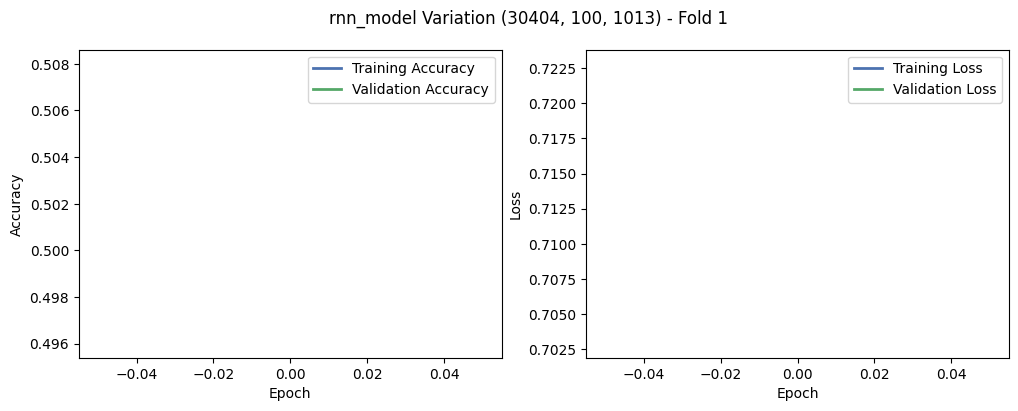

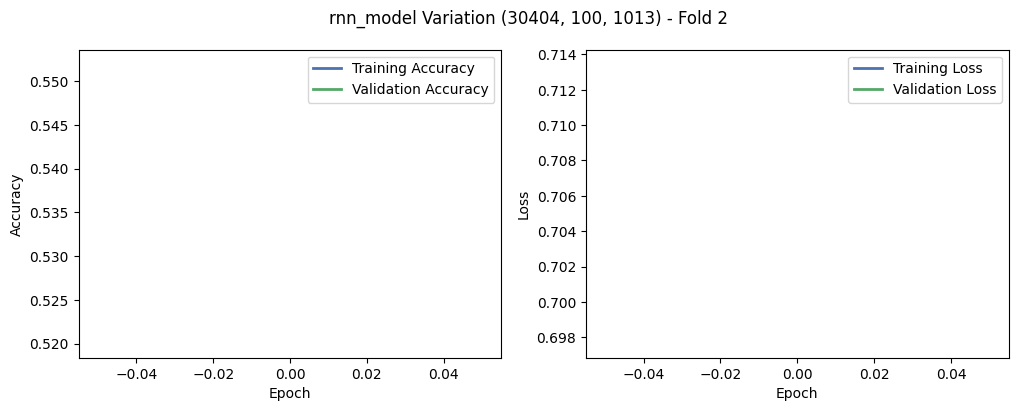

In [67]:
# Visualize the performance of all model variations
for idx, (model_func, variation) in enumerate(model_variations):
    title = f"{model_func.__name__} Variation {variation}"
    for i in range(len(histories)):
        plot_history(histories[i][idx], title=f"{title} - Fold {i+1}")

[1 points] Using the best parameters and architecture from the Transformer in the previous step, add a second Multi-headed self attention layer to your network. That is, the input to the second attention layer should be the output sequence of the first attention layer.  Visualize the performance of training and validation sets versus the training iterations, showing that the model converged.. 


In [68]:
def transformer_model2(input_dim, output_dim, input_length):
    embed_dim = 32
    num_heads = 2
    ff_dim = 32

    inputs = tf.keras.Input(shape=(input_length,))
    embedding_layer = TokenAndPositionEmbedding(input_length, input_dim, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(32, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model

In [69]:
# Train and evaluate transformer_model2
model_variations = [
    (transformer_model2, params),
]

for train_index, test_index in kf.split(X, y):
    print("Fold Number:", len(histories) + 1)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    sub_histories = []
    sub_models = []
    for model_func, variation in model_variations:
        model = model_func(*variation)
        history, model = train_and_evaluate_model(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, epochs=epochs)
        sub_histories.append(history)
        sub_models.append(model)

    histories.append(sub_histories)
    models.append(sub_models)

# Visualize the performance of all model variations
for idx, (model_func, variation) in enumerate(model_variations):
    title = f"{model_func.__name__} Variation {variation}"
    for i, history in enumerate(histories):
        plot_history(history[i][idx], title=f"{title} - Fold {i+1}")

Fold Number: 3
Fold Number: 4


[2 points] Use the method of train/test splitting and evaluation criteria that you argued for at the beginning of the lab. Visualize the results of all the models you trained.  Use proper statistical comparison techniques to determine which method(s) is (are) superior.  


In [70]:
from sklearn.metrics import recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

# Calculate evaluation metrics for all model variations
evaluation_results = []

for model_list in models:
    fold_results = []
    for model in model_list:
        y_pred = model.predict(X_test)  # Assuming X_test and y_test are the test data
        y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

        recall = recall_score(y_test, y_pred_binary)
        f1 = f1_score(y_test, y_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
        specificity = tn / (tn + fp)
        auc_roc = roc_auc_score(y_test, y_pred)

        fold_results.append((recall, f1, specificity, auc_roc))

    evaluation_results.append(fold_results)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [71]:
# Visualize the evaluation metrics
metric_names = ['Recall', 'F1 Score', 'Specificity', 'AUC-ROC']

for idx, (model_func, variation) in enumerate(model_variations):
    title = f"{model_func.__name__} Variation {variation}"
    for i in range(len(evaluation_results)):
        fold_results = evaluation_results[i][idx]

        plt.figure(figsize=(12, 4))
        plt.suptitle(f"{title} - Fold {i+1}")

        for j, metric_name in enumerate(metric_names):
            metric_value = fold_results[j]

            plt.subplot(1, len(metric_names), j+1)
            plt.boxplot([metric_value])
            plt.title(metric_name)
            plt.xlabel('Model Variation')

        plt.show()

In [72]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, classes, title="Confusion matrix"):
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], "d"),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.grid(False)
    plt.show()

classes = ["Real", "Fake"]
for idx, (model_func, variation) in enumerate(model_variations):
    title = f"{model_func.__name__} Variation {variation}"
    for i in range(len(evaluation_results)):
        fold_results = evaluation_results[i][idx]

        # Calculate confusion matrix
        y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions
        cm = confusion_matrix(y_test, y_pred_binary)

        plot_confusion_matrix(cm, classes, title)

### Exceptional Work

Use the pre-trained ConceptNet Numberbatch embedding and compare to pre-trained GloVe. Which method is better for your specific application? 


In [73]:
from keras.layers import Embedding
from keras.initializers import Constant

# Load GloVe embeddings
def load_glove_embeddings(file):
    embeddings = {}
    with open(file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings[word] = coefs
    return embeddings

glove_embeddings = load_glove_embeddings('glove.6B.100d.txt')

# Prepare the embedding matrix
embedding_dim = 100  # This is the dimension of the GloVe embeddings we've loaded
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = glove_embeddings.get(word)
        if embedding_vector is not None:
            # Words not found in the embedding index will be all zeros
            embedding_matrix[i] = embedding_vector

# Define a model using the GloVe embeddings
def model_with_glove_embeddings(input_dim, output_dim, input_length):
    model = Sequential([
        Embedding(input_dim=input_dim,
                  output_dim=output_dim,
                  embeddings_initializer=Constant(embedding_matrix),
                  input_length=input_length,
                  trainable=False),
        LSTM(128, return_sequences=True),
        LSTM(64),
        Dense(1, activation='sigmoid')
    ])
    return model

In [74]:
from keras.layers import Embedding
from keras.initializers import Constant

# Load ConceptNet Numberbatch embeddings
def load_numberbatch_embeddings(file):
    embeddings = {}
    with open(file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings[word] = coefs
    return embeddings

numberbatch_embeddings = load_numberbatch_embeddings('numberbatch-en-19.08.txt')  # adjust the file path and name as needed

# Prepare the embedding matrix
embedding_dim = 300  # This is the dimension of the Numberbatch embeddings
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = numberbatch_embeddings.get(word)
        if embedding_vector is not None:
            # Words not found in the embedding index will be all zeros
            embedding_matrix[i] = embedding_vector

# Define a model using the Numberbatch embeddings
def model_with_numberbatch_embeddings(input_dim, output_dim, input_length):
    model = Sequential([
        Embedding(input_dim=input_dim,
                  output_dim=output_dim,
                  embeddings_initializer=Constant(embedding_matrix),
                  input_length=input_length,
                  trainable=False),
        LSTM(128, return_sequences=True),
        LSTM(64),
        Dense(1, activation='sigmoid')
    ])
    return model

In [75]:
# Define training function
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, epochs=20):
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=0)
    return history, model

/Users/ephraim888sun/.pyenv/versions/3.9.6/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


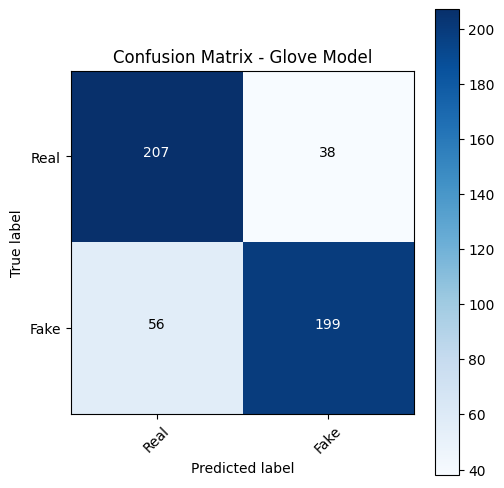

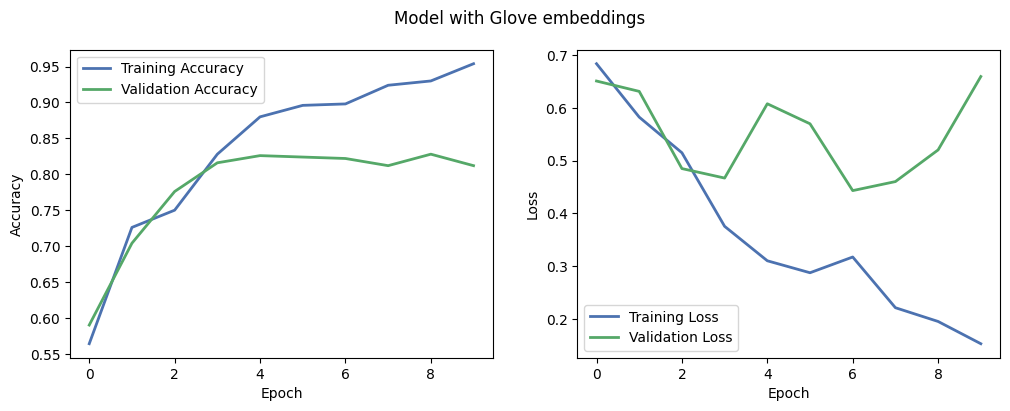

/Users/ephraim888sun/.pyenv/versions/3.9.6/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


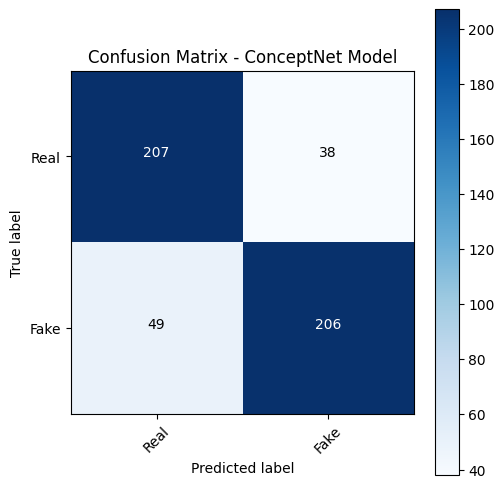

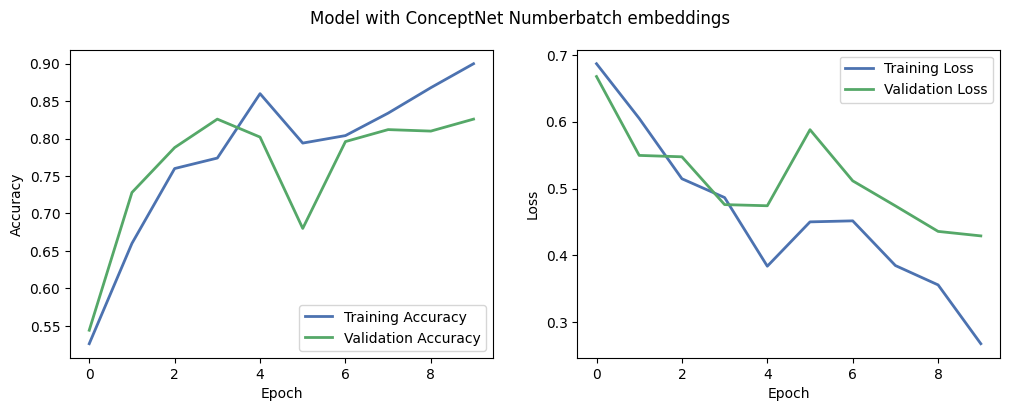

In [76]:
# Define a list of classes
classes = ["Real", "Fake"]

# Train and evaluate the Glove model
model1 = model_with_glove_embeddings(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length)
history1, model = train_and_evaluate_model(model1, X_train, y_train, X_test, y_test, epochs=10)

# Get predictions on test data
y_pred = model.predict(X_test)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate confusion matrix
cm1 = confusion_matrix(y_test, y_pred_binary)

# Plot confusion matrix for Glove model
plot_confusion_matrix(cm1, classes, title='Confusion Matrix - Glove Model')

# Plot the training and validation accuracy and loss
plot_history(history1, title='Model with Glove embeddings')

# Train and evaluate the ConceptNet model
model2 = model_with_numberbatch_embeddings(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length)
history2, model2 = train_and_evaluate_model(model2, X_train, y_train, X_test, y_test, epochs=10)

# Get predictions on test data
y_pred = model2.predict(X_test)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate confusion matrix
cm2 = confusion_matrix(y_test, y_pred_binary)

# Plot confusion matrix for ConceptNet model
plot_confusion_matrix(cm2, classes, title='Confusion Matrix - ConceptNet Model')

# Plot the training and validation accuracy and loss
plot_history(history2, title='Model with ConceptNet Numberbatch embeddings')